# Regression 

In [63]:
import jax.numpy as np
import numpy as onp
import jax
import seaborn as sns
from matplotlib import pyplot as plt
from jax.lib import xla_bridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import ADAMLL as ada
from ADAMLL.activations import relu, sigmoid, eye, tanh
print("jax backend {}".format(xla_bridge.get_backend().platform))

jax backend gpu


## Data

In [64]:
n = 32  # Number of rows
m = 32  # Number of columns
perlin_noise_map = ada.generate_perlin_noise(n, m, seed=9999, scale=0.06) + jax.random.normal(jax.random.PRNGKey(2024), (n, m)) * 0.07

def simplerFunction(x):
    return 0.2*x + 0.8*x**2 + 2*x**3


x shape: (1024, 2)
t shape: (1024, 1)


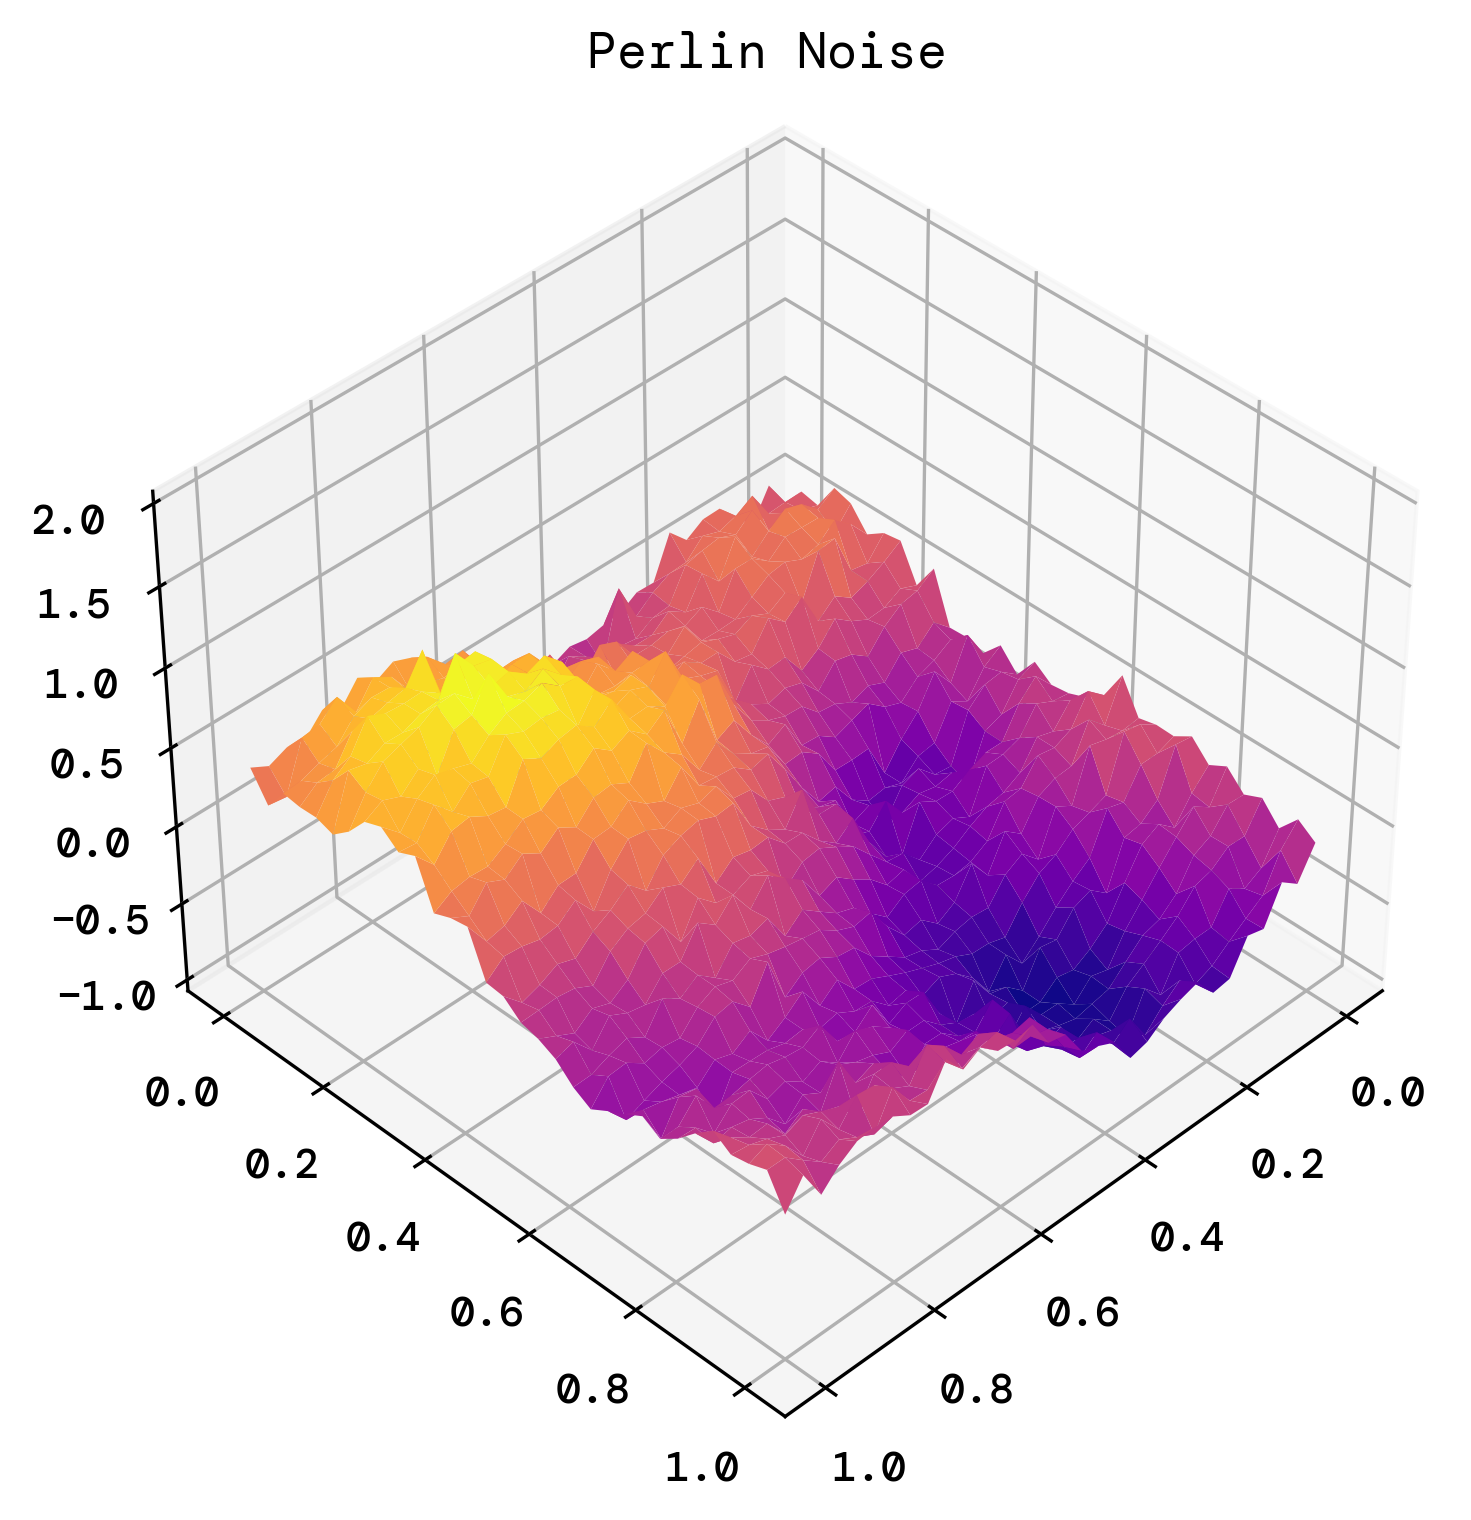

In [65]:
x = np.linspace(0, 1, 32)
y = np.linspace(0, 1, 32)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, perlin_noise_map, cmap='plasma',
                       linewidth=0, antialiased=True)
# fig.colorbar(surf, shrink=0.5, aspect=5)
fig.tight_layout()
ax.set_title("Perlin Noise")
ax.set_zlim(-1.01, 2.01)
ax.view_init(40, 45)
plt.savefig("../runsAndFigures/perlinNoise.png",bbox_inches='tight')


x = np.vstack([X.ravel(), Y.ravel()]).T
y = perlin_noise_map.reshape(-1, 1)

# ax.scatter(x[:, 0], x[:, 1], y, c=y.ravel(), cmap='plasma')
print("x shape: {}".format(x.shape))
print("t shape: {}".format(y.shape))

## Preprocessing

In [66]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

## Automatic differentiation

Training stopped after 99 epochs                                      auto vs manual
auto {'b': Array([0.24602726], dtype=float32), 'w': Array([[ 0.4130881 ],
       [-0.94576377]], dtype=float32)}
manual {'b': Array([0.24602732], dtype=float32), 'w': Array([[ 0.4130881],
       [-0.9457639]], dtype=float32)}


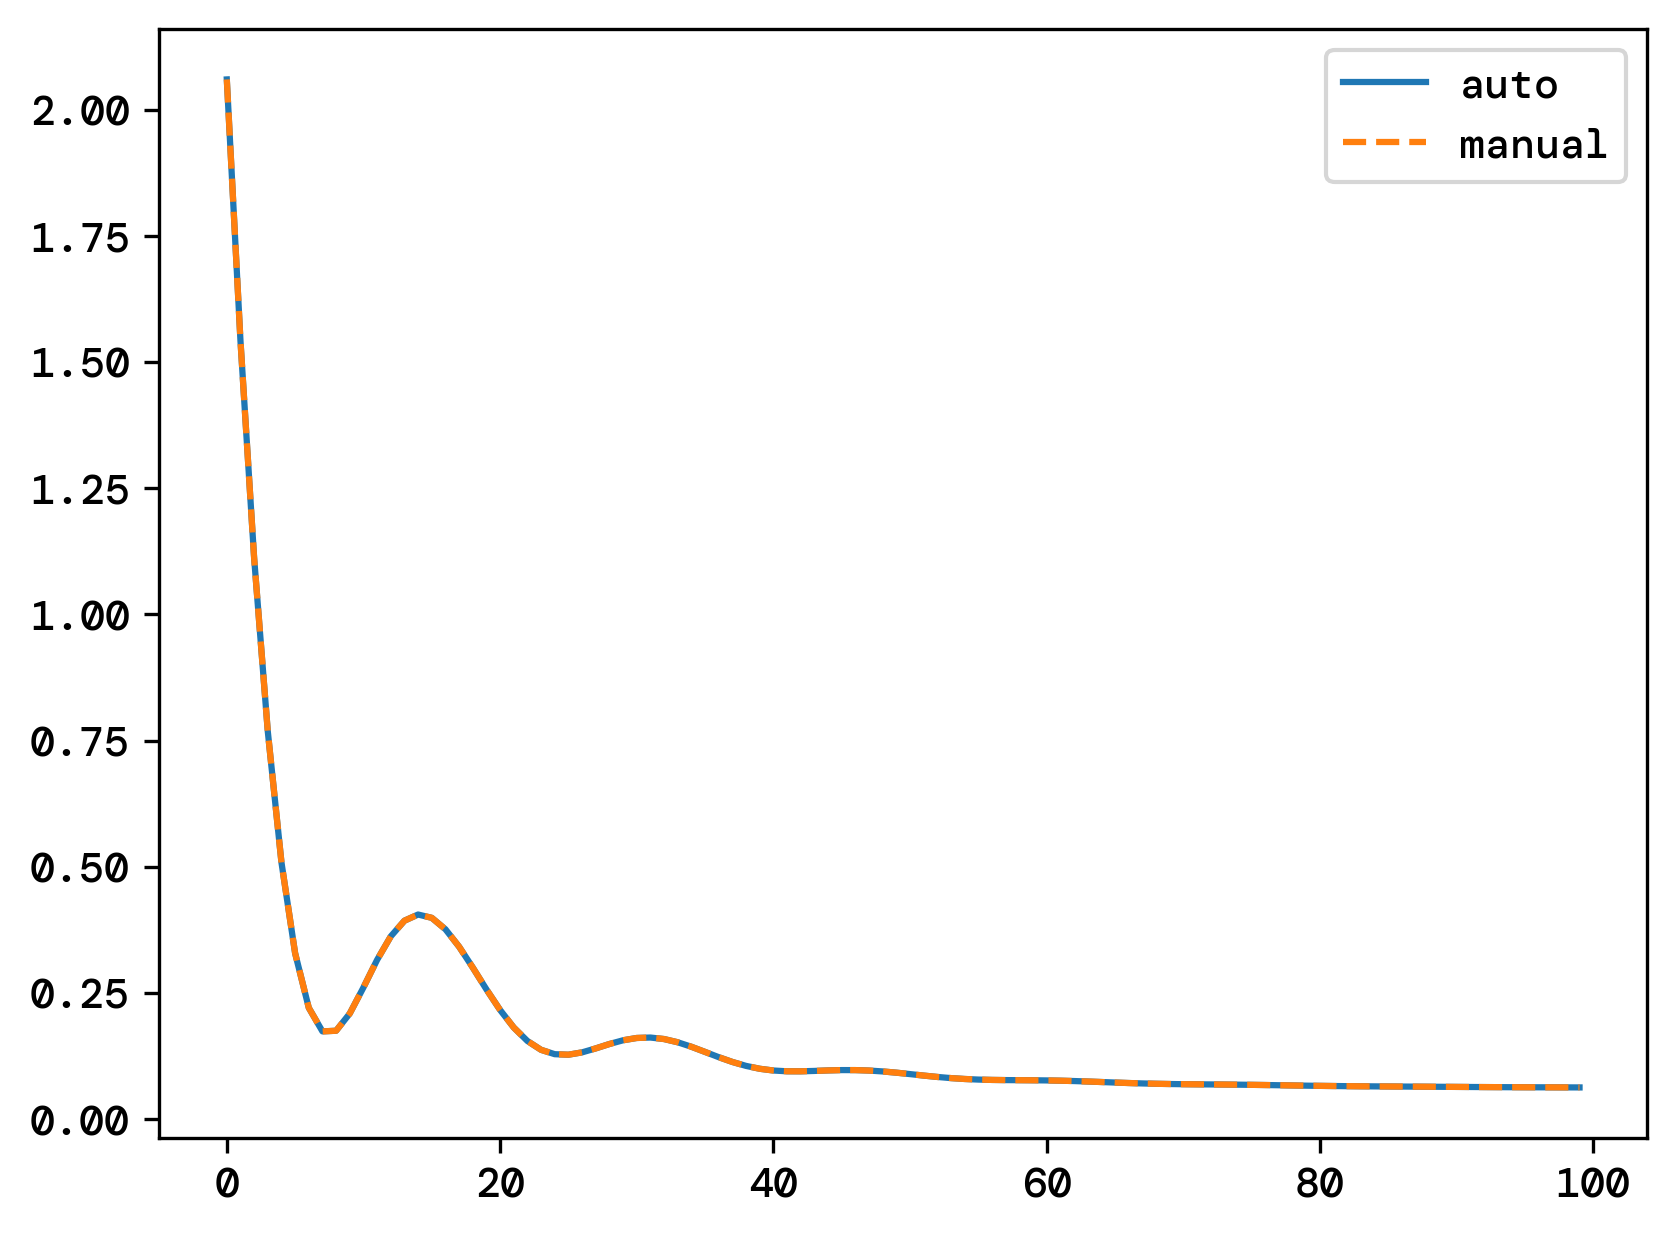

In [67]:
auto = ada.NN.Model([[1,eye]], eta=0.1, epochs=100 , alpha=0,optimizer="adam", loss=ada.MSE, metric=ada.MSE)
manual = ada.NN.Model([[1,eye]], eta=0.1, epochs=100 , backwards=ada.NN.backwards_no_hidden, alpha=0, optimizer="adam", metric=ada.MSE)

lossAuto, params_auto = auto.fit(X_train, y_train, X_test, y_test)
lossManual, params = manual.fit(X_train, y_train, X_test, y_test)

plt.figure()
plt.plot(lossAuto,label="auto")
plt.plot(lossManual,"--", label="manual")
plt.legend()
print("auto vs manual")
print("auto",params_auto[0])
print("manual",params[0])

# Analysis

In [68]:
epochs =200
eta = 0.1
tol = 0.001
epsilon = 1e-8
beta1 = 0.9
beta2 = 0.999
gamma = 0.9
alpha = 0.00001

kfold = KFold(n_splits=6)

def cross_val(X_train, y_train, model, kfold, batch_size=None):
    k = 0
    score = np.zeros(kfold.n_splits)
    for train_ind, test_ind in kfold.split(X_train):
        loss, _ = model.fit(X_train[train_ind], y_train[train_ind], X_train[test_ind], y_train[test_ind], batch_size=batch_size)
        score = score.at[k].set(loss[-1])
        k += 1
    return score.mean(), score.std()


poly = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)


## Learning rate and momentum

In [69]:
gammas = [0.0, 0.1, 0.5, 0.9]
etas = [ 0.0001, 0.001, 0.01, 0.1  ]
scores_lr_gamma = onp.zeros((len(etas), len(gammas)))
for i, e in enumerate(etas):
    for j, g in enumerate(gammas):
        model =  ada.NN.Model([[1,eye]], e, epochs, tol, "sgd", alpha, g, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE)
        mean , _ = cross_val(X_train_poly, y_train, model, kfold)
        scores_lr_gamma[i, j] = mean
    print(ada.progress_bar(i*len(gammas) + j, len(etas)*len(gammas)))

Training stopped after 199 epochs                                     Progress: [-->                 ] 18%
Training stopped after 199 epochs                                     Progress: [------->            ] 43%
Training stopped after 199 epochs                                     Progress: [------------>       ] 68%
Training stopped after 199 epochs                                     Progress: [----------------->  ] 93%


In this case havving momentum seems to be beneficial. We maxes out our testing range and found that 0.9 was the best value for momentum. momentum allows a higher learning rate

## Regularization

In [70]:
alphas = [0, 0.0001, 0.001, 0.01, 0.1]
scores_alpha = onp.zeros((len(alphas), 2) )
for i, a in enumerate(alphas):
    model =  ada.NN.Model([[1,eye]], eta, epochs, tol, "sgd", a, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE) 
    mean, var = cross_val(X_train_poly, y_train, model, kfold)
    scores_alpha[i] = [mean, var] 
    print(ada.progress_bar(i, len(alphas)))

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [--->                ] 20%
Training stopped after 199 epochs                                     Progress: [------->            ] 40%
Training stopped after 199 epochs                                     Progress: [----------->        ] 60%
Training stopped after 199 epochs                                     Progress: [--------------->    ] 80%


## Batch size

In [71]:
batch_sizes = [ 50, 100, 500, None ] 
score_batches = onp.zeros((len(batch_sizes), 2))
for i, batch_size in enumerate(batch_sizes):
    model =  ada.NN.Model([[1,eye]], 0.001, epochs, tol, "sgd", alpha, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE) 
    mean, var = cross_val(X_train_poly, y_train, model, kfold, batch_size=batch_size)
    score_batches[i] = [mean, var]
    print(ada.progress_bar(i, len(batch_sizes)))

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [---->               ] 25%
Training stopped after 199 epochs                                     Progress: [--------->          ] 50%
Training stopped after 199 epochs                                     Progress: [-------------->     ] 75%


## Optimizers

In [72]:
optimizer_names = ['adam', 'adagrad', 'rmsprop', 'sgd']
scores_optimizer = onp.zeros((len(optimizer_names), 2) )
for i, optimizer in enumerate(optimizer_names):
    model =  ada.NN.Model([[1,eye]], eta, epochs, tol, optimizer, a, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE) 
    mean, var = cross_val(X_train_poly, y_train, model, kfold)
    scores_optimizer[i] = [mean, var]
    print(ada.progress_bar(i, len(optimizer_names)))


Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [---->               ] 25%
Training stopped after 199 epochs                                     Progress: [--------->          ] 50%
Training stopped after 199 epochs                                     Progress: [-------------->     ] 75%


## Degree of polynomial

In [73]:
degrees = [5, 8, 10,15]
scores_degree = onp.zeros((len(degrees), 2) )
for i, d in enumerate(degrees):
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    X_train_poly = scaler.fit_transform(X_train_poly)
    X_test_poly = scaler.transform(X_test_poly)
    model =  ada.NN.Model([[1,eye]], 0.01, epochs, tol, "sgd", alpha, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE) 
    mean, var = cross_val(X_train_poly, y_train, model, kfold)
    scores_degree[i] = [mean, var]
    print(ada.progress_bar(i, len(degrees)))


Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [---->               ] 25%
Training stopped after 199 epochs                                     Progress: [--------->          ] 50%
Training stopped after 199 epochs                                     Progress: [-------------->     ] 75%


## Layers
important to remove the polynomial features when using a neural network

In [74]:
X_train_scaled = scaler.fit_transform(X_train)

n_layers = [1,2, 3, 4, 5]
n_nodes  = [2, 3, 5, 10]
scores_layers_nodes = onp.zeros((len(n_layers), len(n_nodes) ) )
for i, n_layer in enumerate(n_layers):
    for j, n_node in enumerate(n_nodes):
        model =  ada.NN.Model([[n_node,relu]]*n_layer + [[1,eye]], eta, epochs, tol, "adam", alpha, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE) 
        mean, var = cross_val(X_train_scaled, y_train, model, kfold)
        scores_layers_nodes[i, j] = mean
    print(ada.progress_bar(i, len(n_layers)))


Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [--->                ] 20%
Training stopped after 199 epochs                                     Progress: [------->            ] 40%
Training stopped after 199 epochs                                     Progress: [----------->        ] 60%
Training stopped after 199 epochs                                     Progress: [--------------->    ] 80%


## Activation functions

In [75]:
acitvs = [relu, sigmoid, tanh]
scores_activs = onp.zeros((len(acitvs), 2) )
for i, activ in enumerate(acitvs):
    model =  ada.NN.Model([[10,activ],[1,eye]], eta, epochs, tol, "adam", alpha, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE) 
    mean, var = cross_val(X_train, y_train, model, kfold)
    scores_activs[i] = [mean, var]
    print(ada.progress_bar(i, len(acitvs)))

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [----->              ] 33%
Training stopped after 199 epochs                                     Progress: [------------>       ] 66%


## Plot

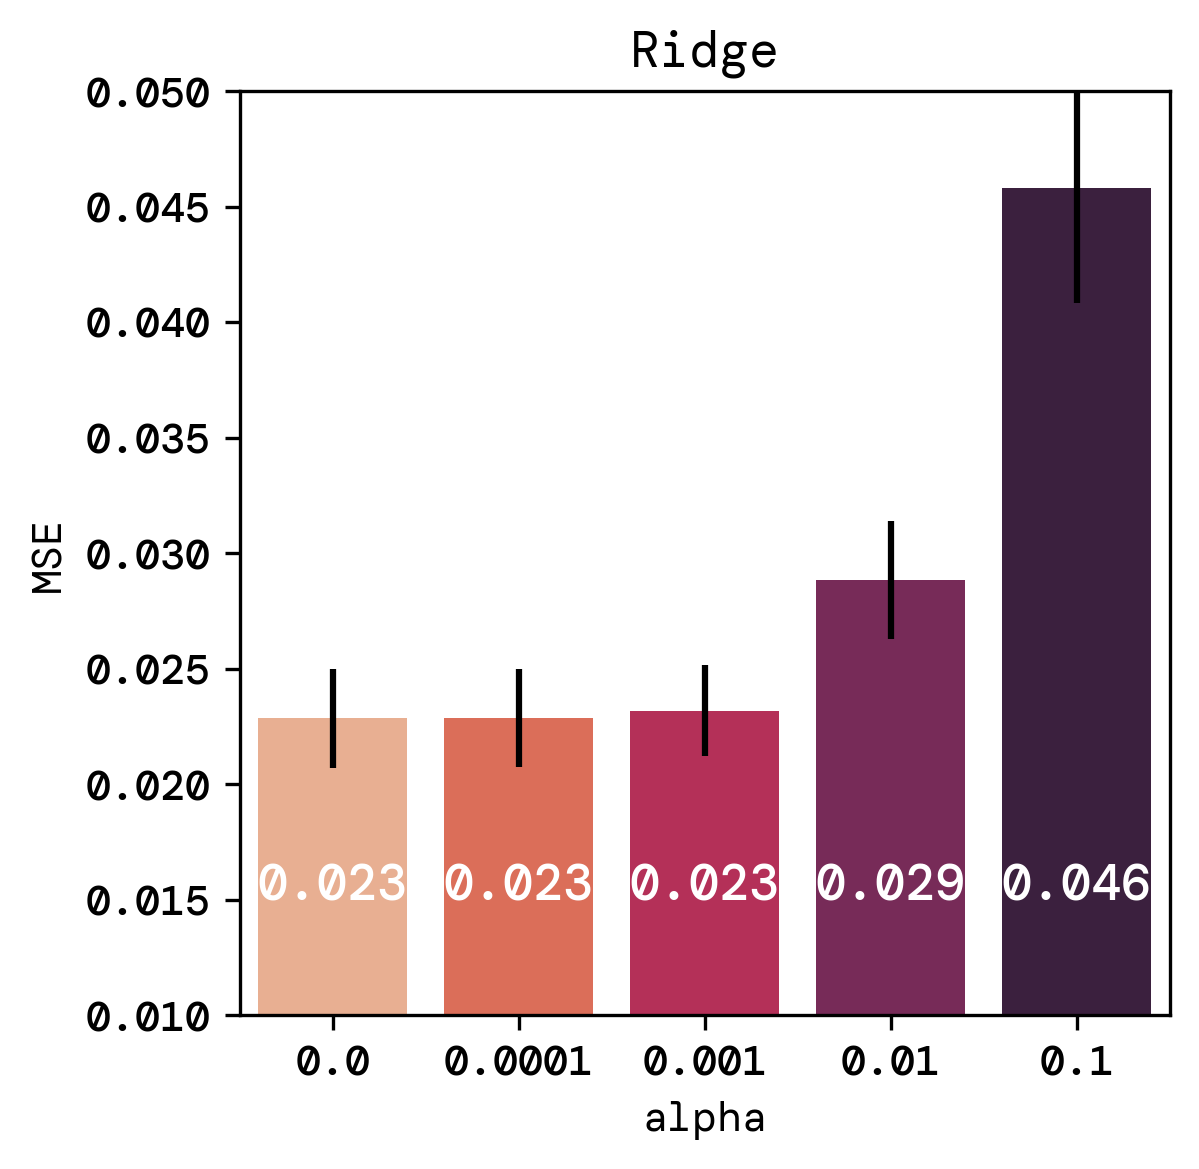

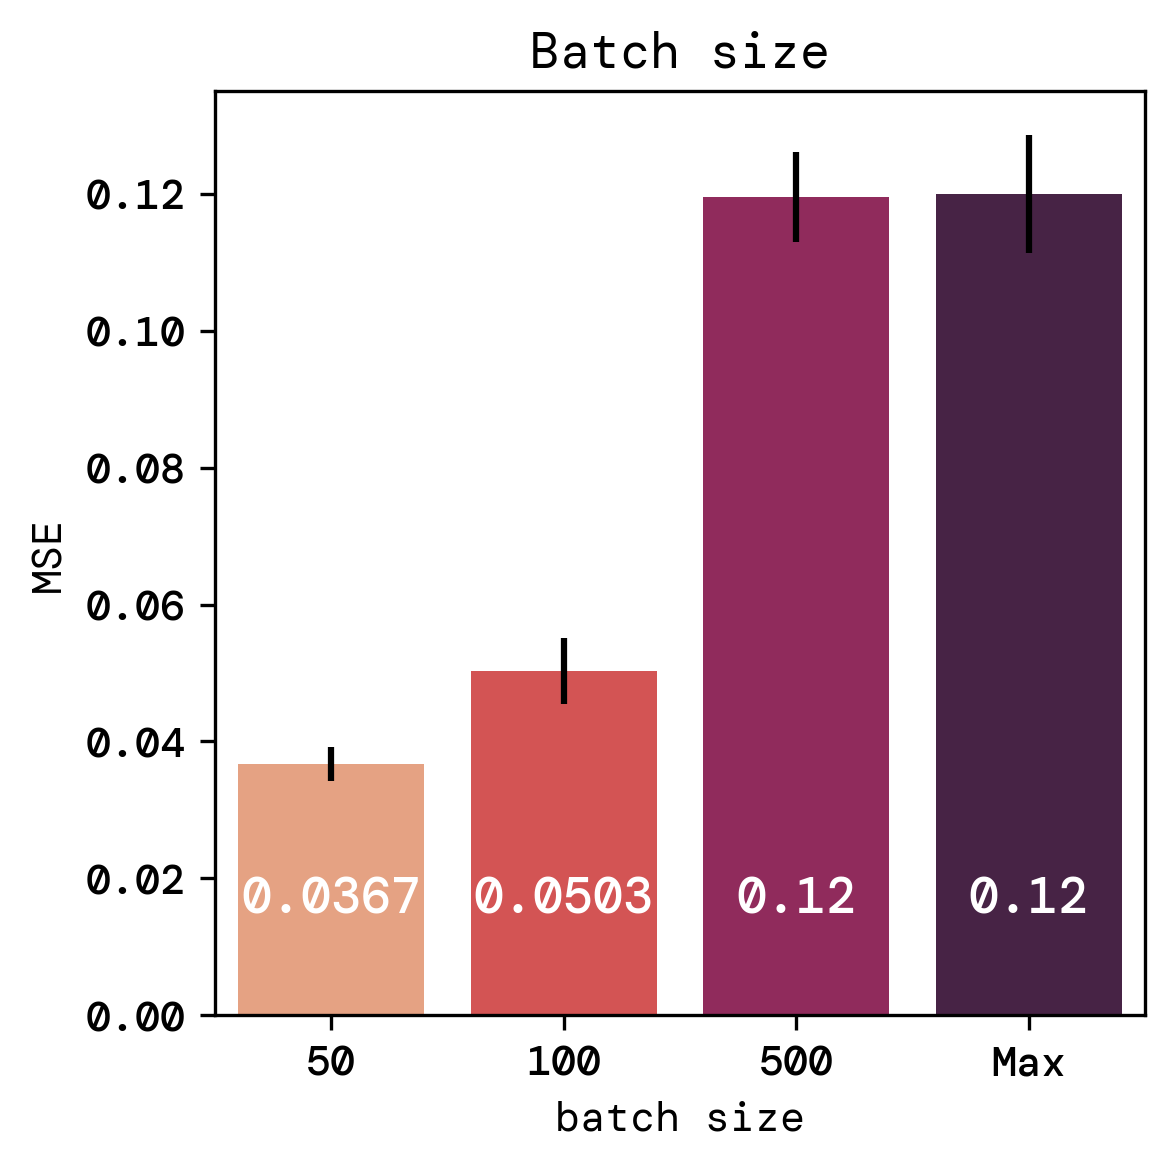

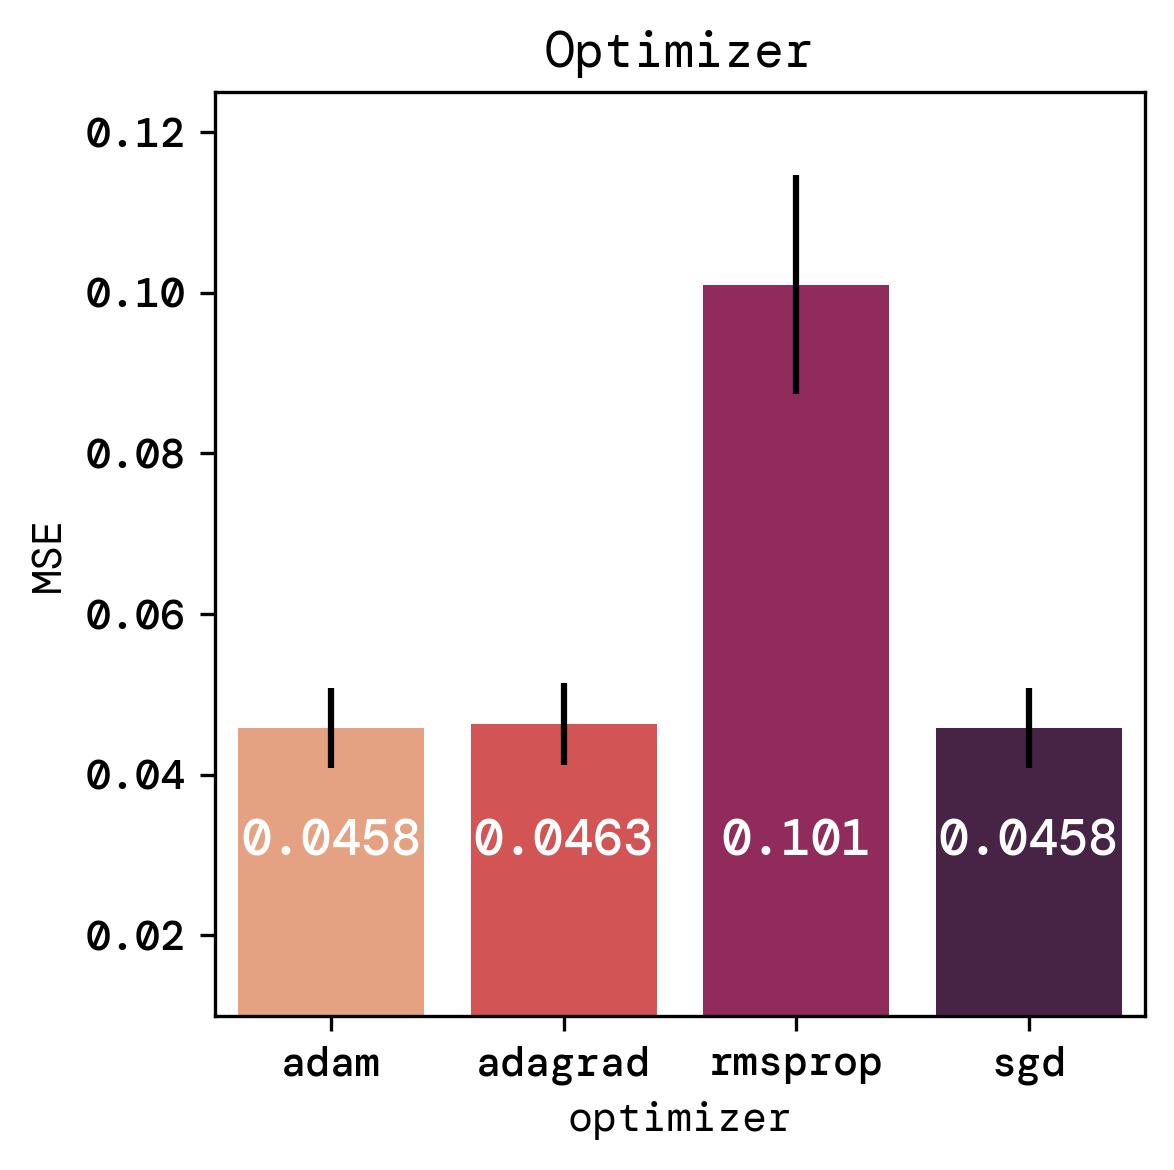

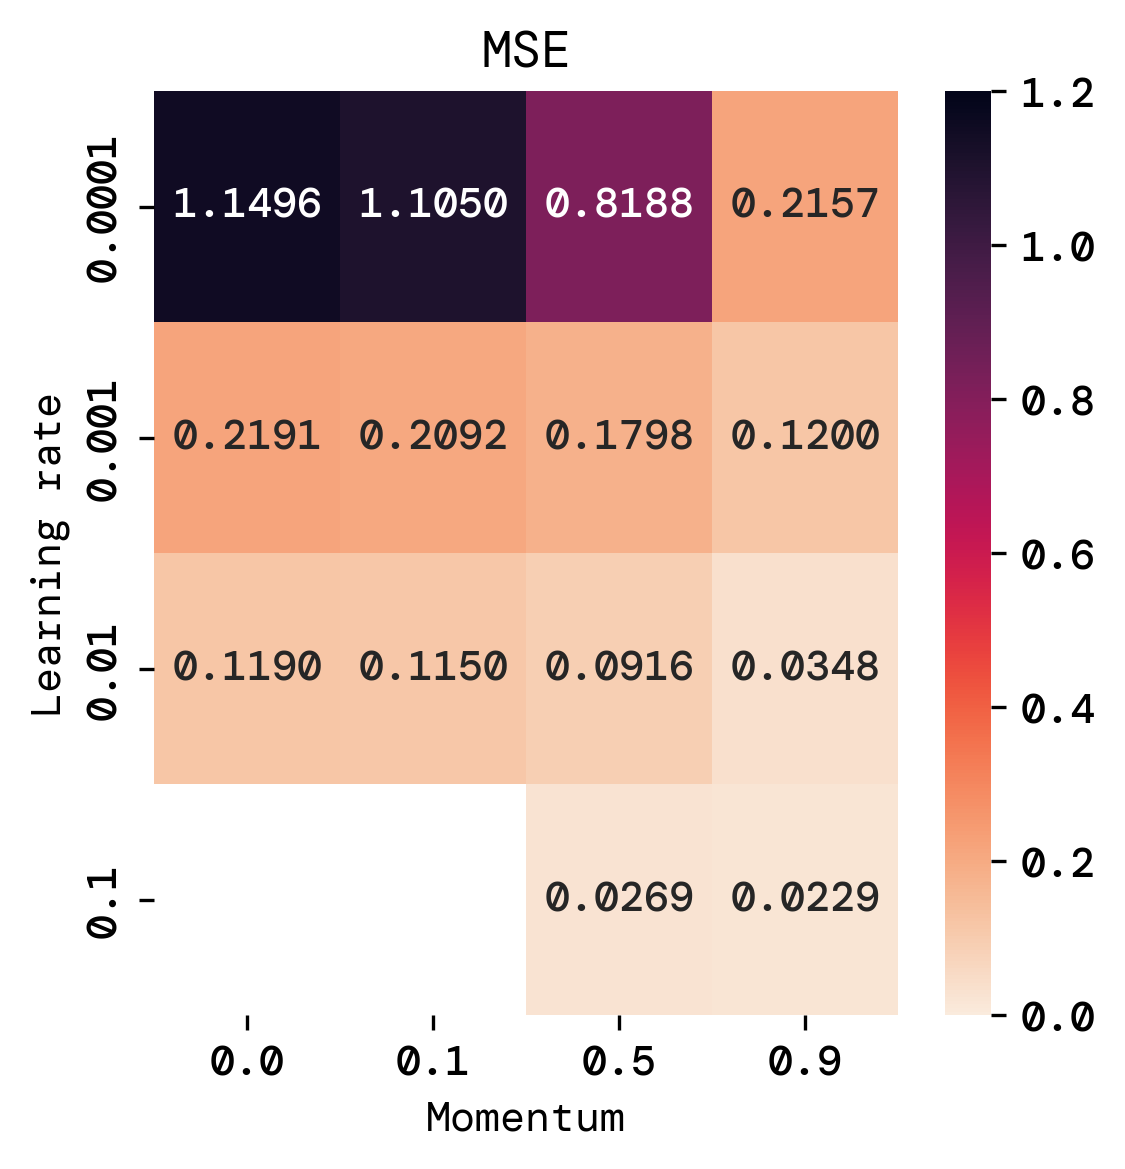

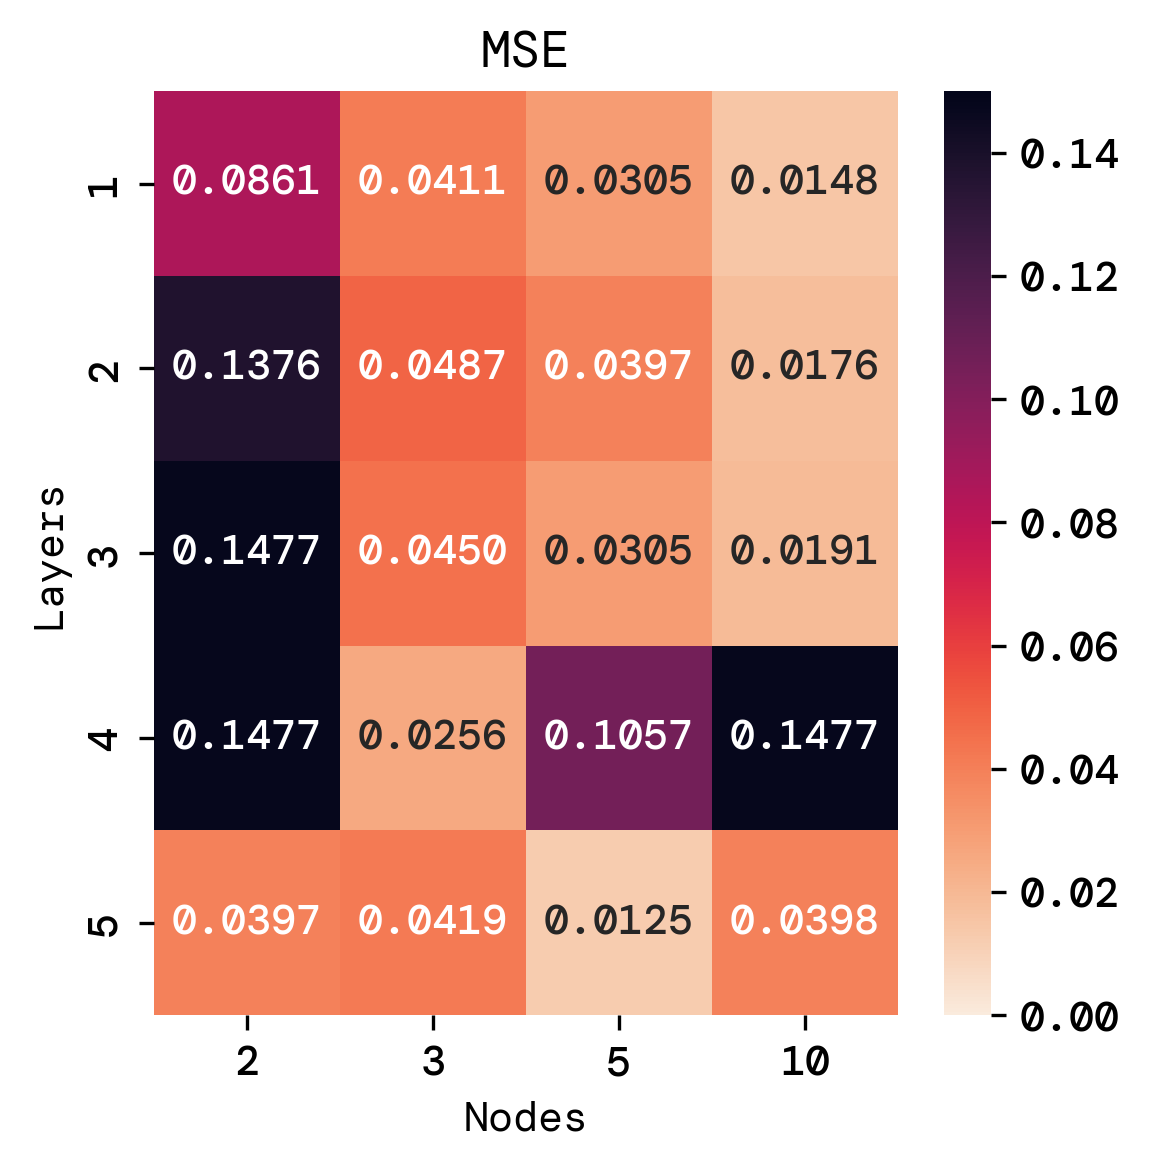

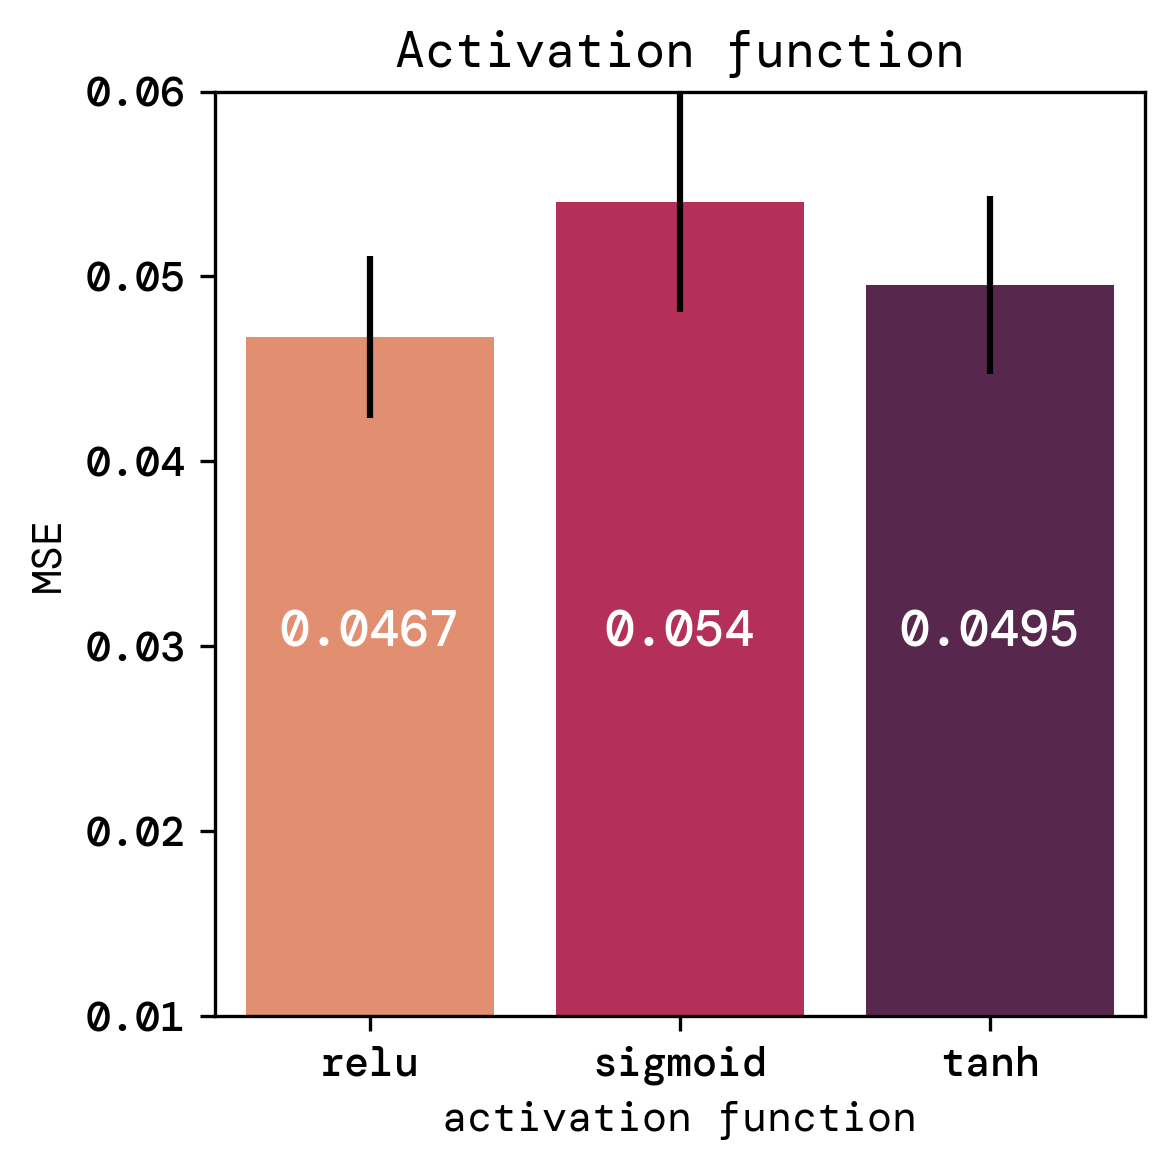

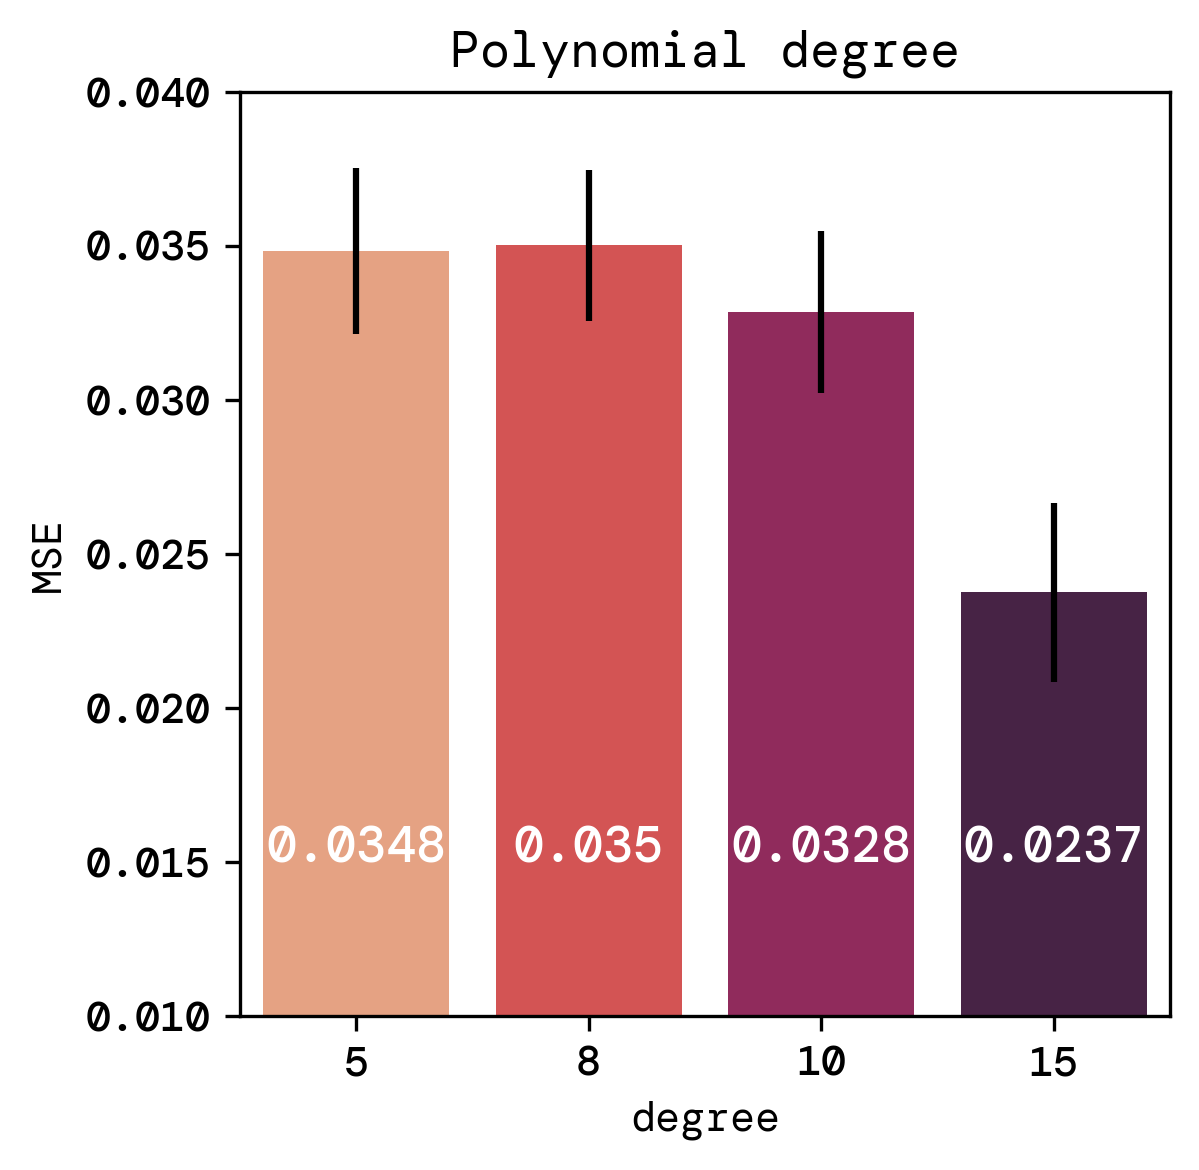

In [131]:
plt.figure(figsize=(4,4))
ax = sns.barplot(x=alphas, y=scores_alpha[:,0], palette="rocket_r", yerr=scores_alpha[:,1])
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("Ridge")
ax.set_ylim(0.01, 0.05)
ax.text(0, 0.015, f"{scores_alpha[0,0]:.2}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.015, f"{scores_alpha[1,0]:.2}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.015, f"{scores_alpha[2,0]:.2}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.015, f"{scores_alpha[3,0]:.2}", ha='center',  fontsize=12, color='white')
ax.text(4, 0.015, f"{scores_alpha[4,0]:.2}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_alpha.png",bbox_inches='tight')
plt.show()


plt.figure(figsize=(4,4))
batch_sizes = [ 50, 100, 500, "Max" ]
ax = sns.barplot(x=batch_sizes, y=score_batches[:,0], yerr=score_batches[:,1], palette="rocket_r")
ax.set_xlabel("batch size")
ax.set_ylabel("MSE")
ax.set_title("Batch size")
ax.text(0, 0.015, f"{score_batches[0,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.015, f"{score_batches[1,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.015, f"{score_batches[2,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.015, f"{score_batches[3,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_batch.png",bbox_inches='tight')
plt.show()


plt.figure(figsize=(4,4))
ax = sns.barplot(x=optimizer_names, y=scores_optimizer[:,0], yerr=scores_optimizer[:,1], palette="rocket_r")
ax.set_xlabel("optimizer")
ax.set_ylabel("MSE")
ax.set_title("Optimizer")
ax.set_ylim(0.01, 0.125)
ax.text(0, 0.03, f"{scores_optimizer[0,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.03, f"{scores_optimizer[1,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.03, f"{scores_optimizer[2,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.03, f"{scores_optimizer[3,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_optimizer.png",bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
ax = sns.heatmap(scores_lr_gamma, annot=True, fmt=".4f", cmap="rocket_r", vmax=1.2, vmin=0.0)
ax.set_title("MSE")
ax.set_xlabel("Momentum")
ax.set_xticklabels(gammas)
ax.set_ylabel("Learning rate")
ax.set_yticklabels(etas)
plt.savefig("../runsAndFigures/MSE_lr_gamma.png",bbox_inches='tight')
plt.show()


plt.figure(figsize=(4,4))
ax = sns.heatmap(scores_layers_nodes, annot=True, fmt=".4f", cmap="rocket_r", vmax=0.15, vmin=0.0)
ax.set_title("MSE")
ax.set_xlabel("Nodes")
ax.set_xticklabels(n_nodes)
ax.set_ylabel("Layers")
ax.set_yticklabels(n_layers)
plt.savefig("../runsAndFigures/MSE_layers_nodes.png",bbox_inches='tight')
plt.show()


plt.figure(figsize=(4,4))
activs_names = ["relu", "sigmoid", "tanh"]
ax = sns.barplot(x=activs_names, y=scores_activs[:,0], yerr=scores_activs[:,1], palette="rocket_r")
ax.set_xlabel("activation function")
ax.set_ylabel("MSE")
ax.set_title("Activation function")
ax.set_ylim(0.01, 0.06)
ax.text(0, 0.03, f"{scores_activs[0,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.03, f"{scores_activs[1,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.03, f"{scores_activs[2,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_activs.png",bbox_inches='tight')



plt.figure(figsize=(4,4))
ax = sns.barplot(x=degrees, y=scores_degree[:,0], yerr=scores_degree[:,1], palette="rocket_r")
ax.set_xlabel("degree")
ax.set_ylabel("MSE")
ax.set_title("Polynomial degree")
ax.set_ylim(0.01, 0.04)
ax.text(0, 0.015, f"{scores_degree[0,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.015, f"{scores_degree[1,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.015, f"{scores_degree[2,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.015, f"{scores_degree[3,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_degree.png",bbox_inches='tight')
plt.show()




## Final evaluations and fine tuning
#### fine tuning single layer

In [139]:
# manual fine tuning
# best hyperparameters
eta = 0.01
epochs = 100
tol = 0.001
alpha = 0.0001
gamma = 0.9
epsilon = 1e-8
beta1 = 0.6
beta2 = 0.999
batch_size = None

poly = PolynomialFeatures(degree=15, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)
model =  ada.NN.Model([[1,eye]], eta, epochs, tol, "sgd", alpha, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE) 
mean, var = cross_val(X_train_poly, y_train, model, kfold, batch_size=batch_size)

print("Mse train: ", mean)


Training stopped after 99 epochs                                      Mse train:  0.029172068


Training stopped after 99 epochs                                      Mse test:  0.028290479


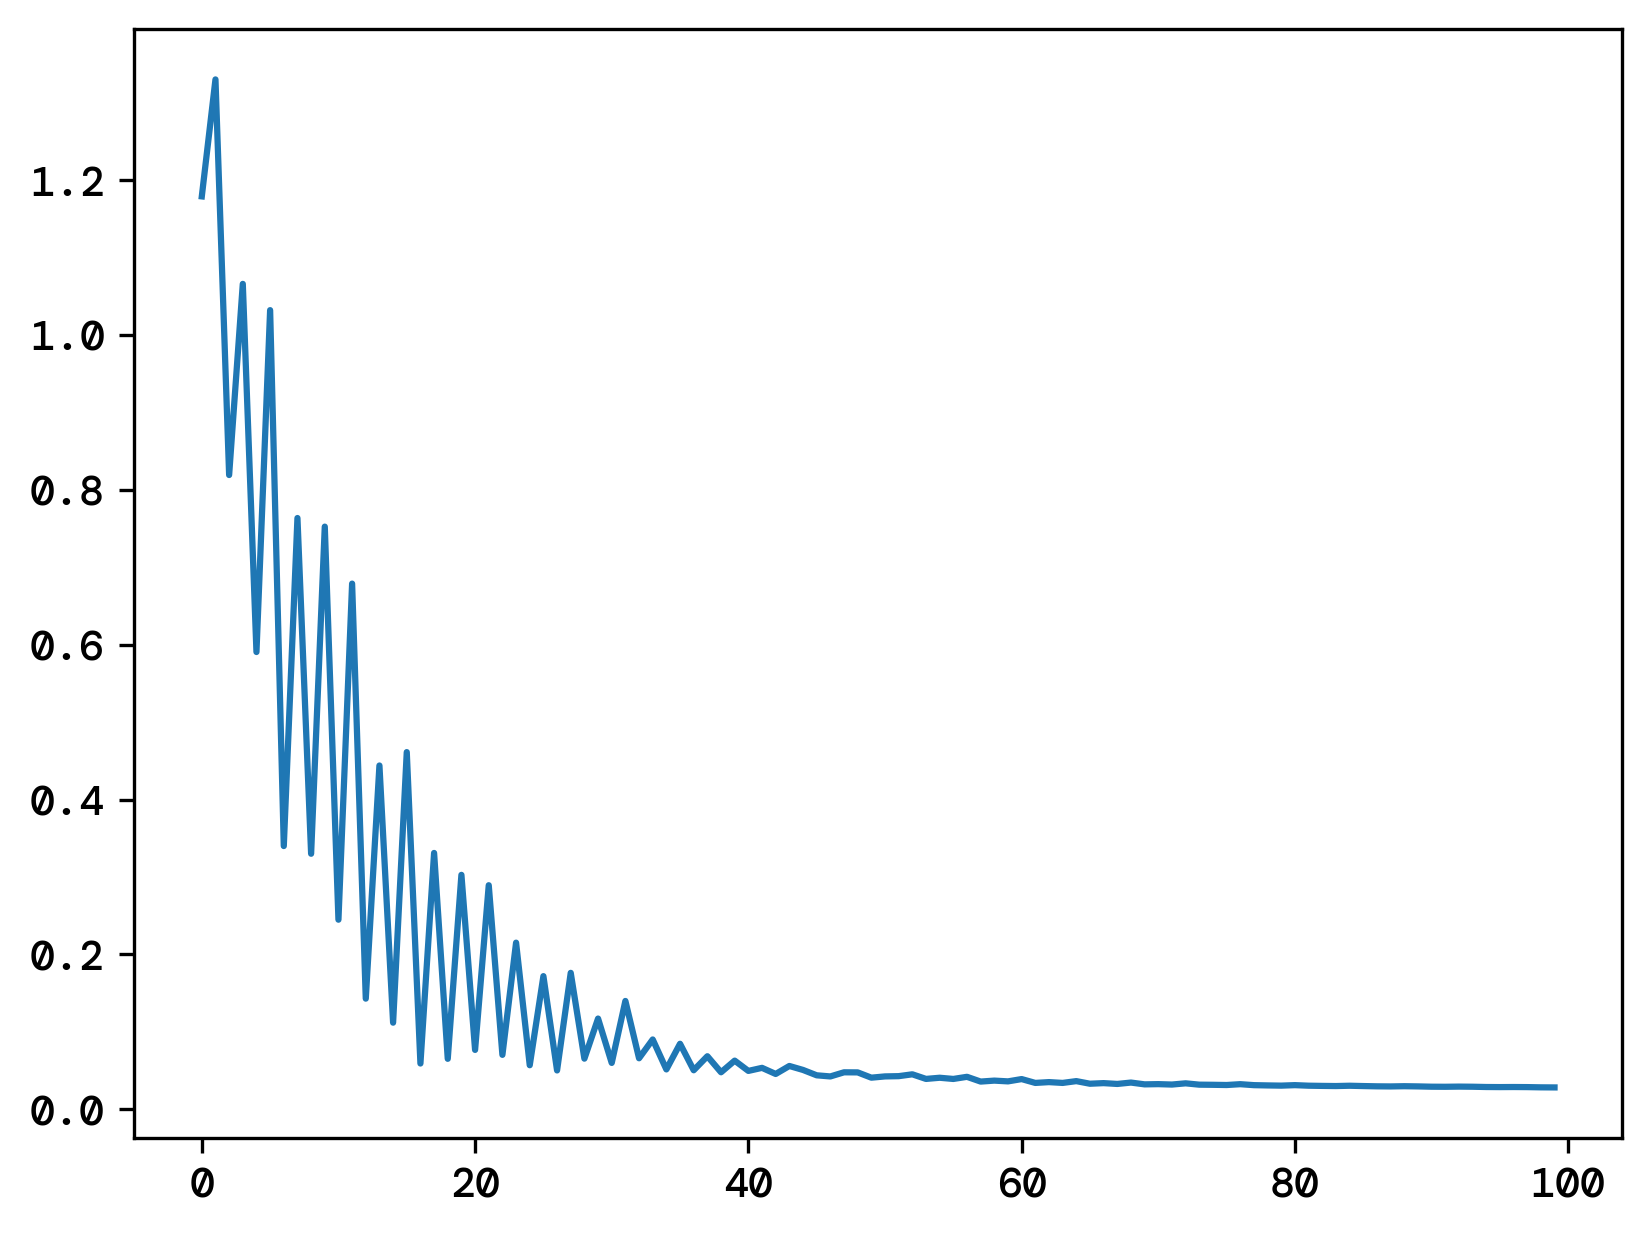

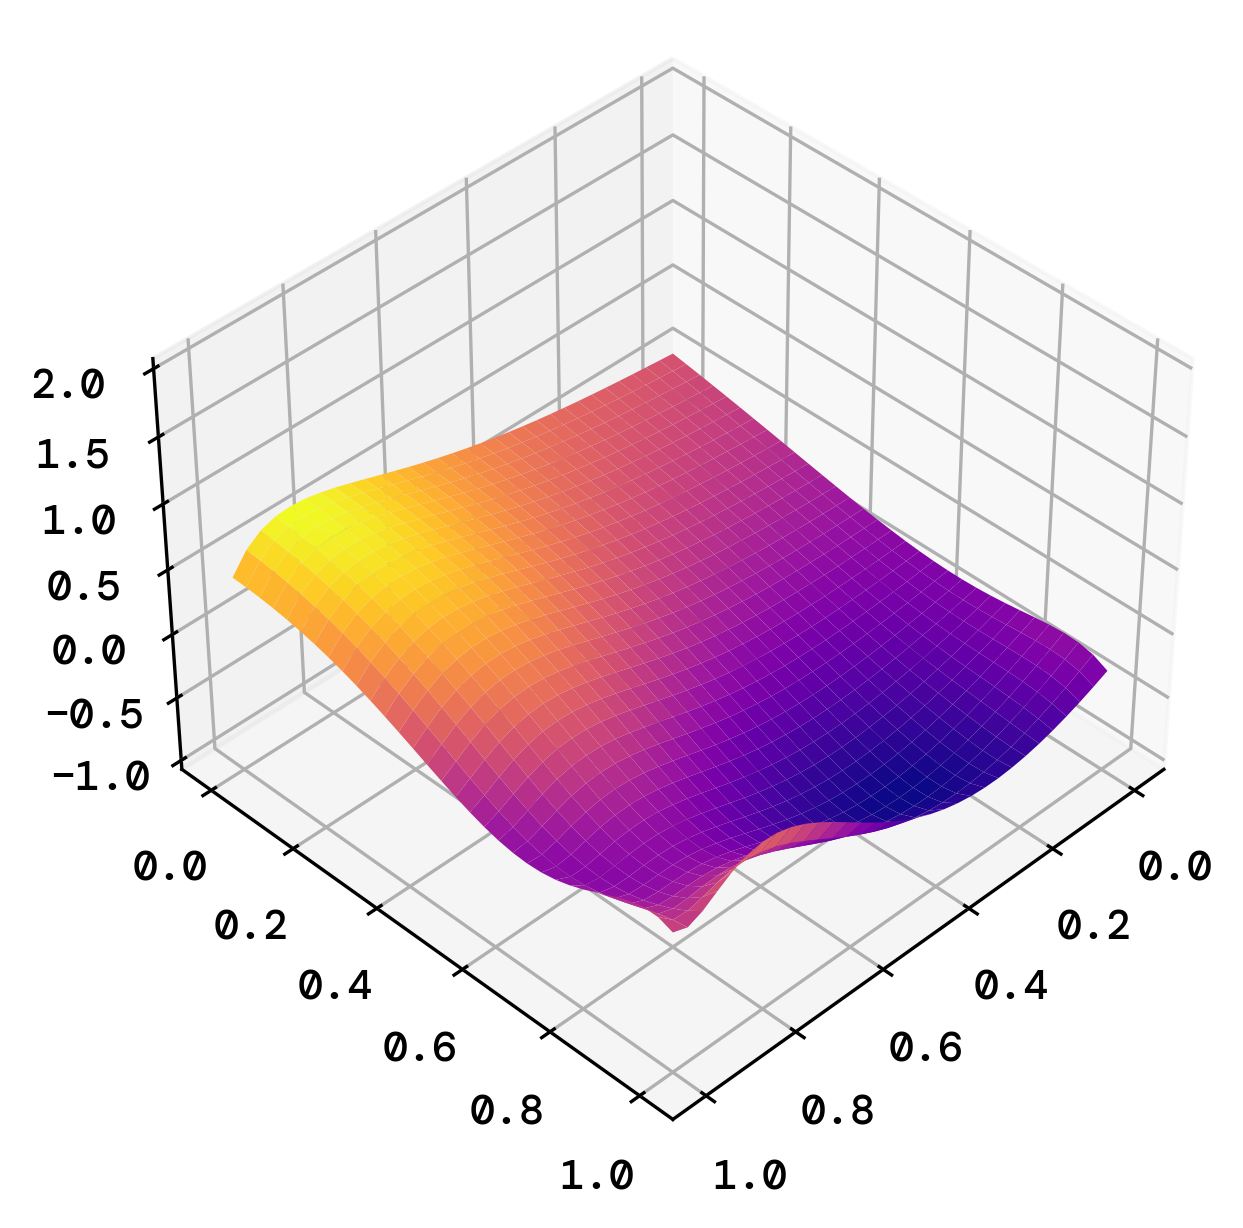

In [141]:
loss, _ = model.fit(X_train_poly, y_train, X_test_poly, y_test, batch_size=batch_size)

plt.plot(loss)
print("Mse test: ", loss[-1])


y_pred = model.predict(scaler.transform(poly.transform(x)))
y_pred = y_pred.reshape(32, 32)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(4,4))
surf = ax.plot_surface(X, Y, y_pred, cmap='plasma',
                       linewidth=0, antialiased=True)
# fig.colorbar(surf, shrink=0.5, aspect=5)
fig.tight_layout()
ax.set_zlim(-1.01, 2.01)
ax.view_init(40, 45)
plt.savefig("../runsAndFigures/perlinNoise_logistic_pred.png",bbox_inches='tight')
plt.show()

### Fine tuning Neural network

In [143]:
# manual fine tuning
# best hyperparameters
eta = 0.01
epochs = 100
tol = 0.001
alpha = 0.0001
gamma = 0.9
epsilon = 1e-8
beta1 = 0.9
beta2 = 0.999
batch_size = None

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = ada.NN.Model([[5,relu],[5,relu],[5,relu],[5,relu],[5,relu],[1,eye]], eta, epochs, tol, "adam", alpha, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE)

mean, var = cross_val(X_train_scaled, y_train, model, kfold, batch_size=batch_size)

# matrix = ada.confusion_matrix(model.classify(X_test), y_test)
# print(matrix)
print("Mse: ", mean)






Training stopped after 99 epochs                                      Mse:  0.01043241


Training stopped after 99 epochs                                      test mse:  0.012574881


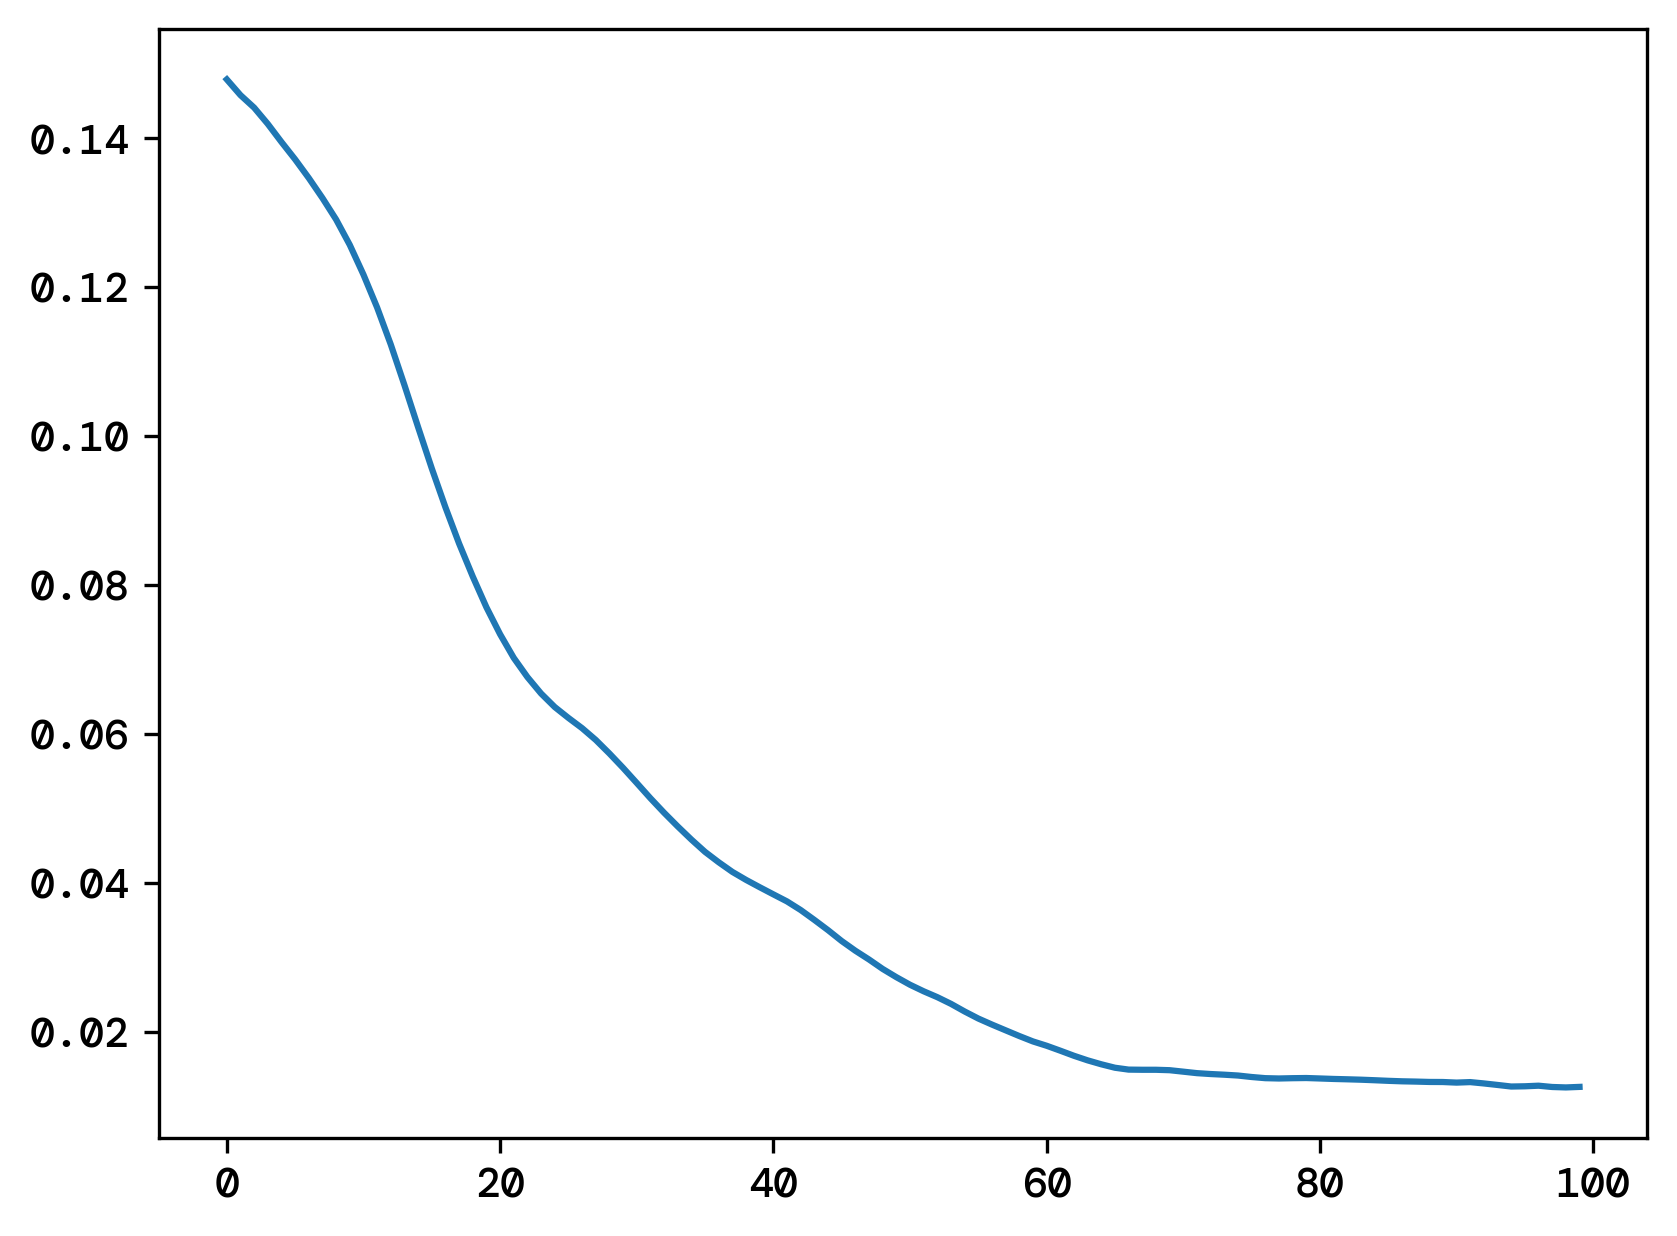

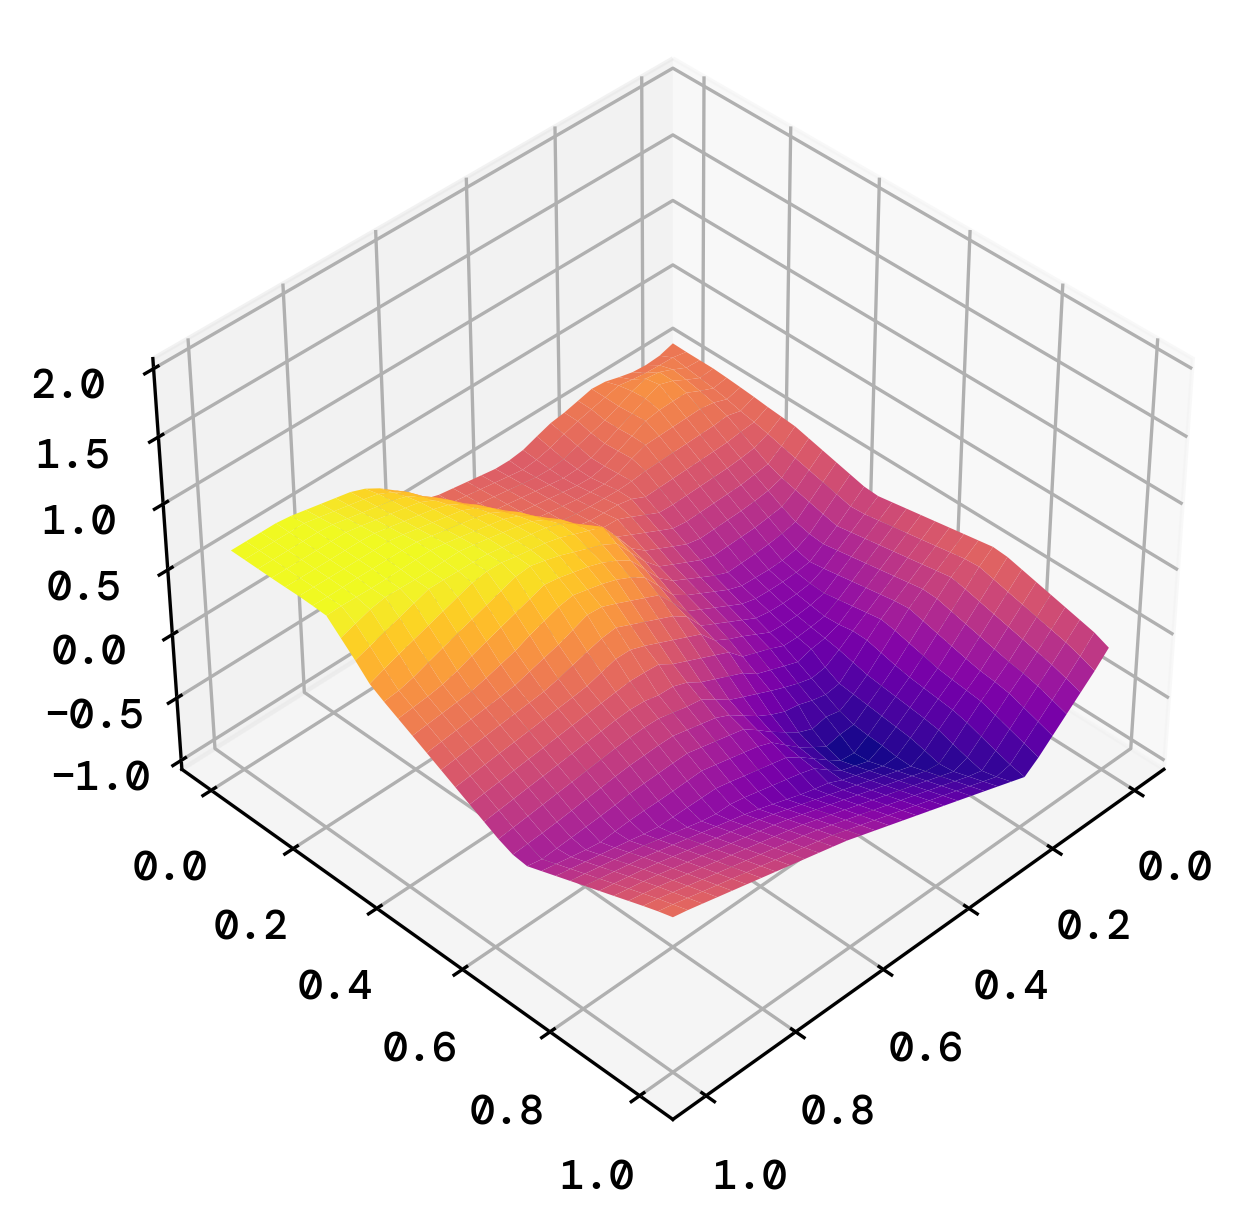

In [144]:
loss, params = model.fit(X_train_scaled, y_train, X_test_scaled, y_test, batch_size=batch_size)

y_pred = model.predict(scaler.transform(x))

plt.plot(loss)
print("test mse: ", loss[-1])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(4,4))
surf = ax.plot_surface(X, Y, y_pred.reshape(32,32), cmap='plasma',
                       linewidth=0, antialiased=True)
fig.tight_layout()
ax.set_zlim(-1.01, 2.01)
ax.view_init(40, 45)
plt.savefig("../runsAndFigures/perlinNoise_NN_pred.png",bbox_inches='tight')